In [ ]:
!pip install nlp transformers texttable &> /dev/null
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List
import re
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)  
from texttable import Texttable

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, IterableDataset
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel, BertConfig, \
     AdamW, set_seed, AutoConfig, PreTrainedTokenizer, DataCollator, PreTrainedModel, PreTrainedTokenizer, DataCollator, PreTrainedModel

set_seed(23)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Class to store data samples, text_a, text_b
@dataclass
class Example:
    text_a: str
    text_b: str
    cui_embedding_a: list
    cui_embedding_b: list


# lowercase and add space around words, remove unnecessary spaces
def pre_process(sentence, cased=False):
    sentence = sentence.replace(":", " : ").replace("/", " / ")\
               .replace("[", " [ ").replace("]", " ] ").replace("(", " ( ")\
               .replace(")", " ) ").replace("\"", " \" ").replace("-", " - ")\
               .replace("?", " ").lstrip().rstrip()
    if cased:
      return re.sub(' +',' ', sentence)
    return re.sub(' +',' ', sentence).lower()


# returns test and train arrays as Example Objects
# test train split is stratified and 80-20 split
def get_test_data(cased=False):
    train_data = "/content/drive/My Drive/clinical-sts/augmented_test_with_cui_embeddings.tsv"
    df = pd.read_csv(train_data, sep="\t", names=["sentence_1", "sentence_2", "gold_score", "label", "cuis_1", "cuis_2", "cui_embedding_1", "cui_embedding_2"], encoding="utf-8")
    df["sentence_1"] = df["sentence_1"].apply(lambda sentence: pre_process(sentence, cased))
    df["sentence_2"] = df["sentence_2"].apply(lambda sentence: pre_process(sentence, cased))
    df["input_sample"] = df["sentence_1"] + "<SEP>" + df["sentence_2"] + "<SEP>" + df["cui_embedding_1"] + "<SEP>" + df["cui_embedding_2"]

    test = [Example(text_a=sample.split("<SEP>")[0], 
                    text_b=sample.split("<SEP>")[1],
                    cui_embedding_a=list(map(float, sample.split("<SEP>")[2].split(","))),
                    cui_embedding_b=list(map(float, sample.split("<SEP>")[3].split(",")))) for sample in df["input_sample"]]

    return test




# DYNAMIC PADDING AND UNIFORM LENGTH BATCHING - reduces wasted computation and makes it faster to run
# CODE BORROWED FROM https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e


# We'll be creating a custome dataset using this first
@dataclass
class Features:
    og_sample: Example
    cui_embedding: List[float]
    input_ids: List[int]
    attention_mask: List[int]


class TextDataset(Dataset):
    def __init__(self, tokenizer, 
                 pad_to_max_length, 
                 max_len,
                 examples: List[Example]):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.examples: List[Example] = examples
        self.current = 0
        self.pad_to_max_length = pad_to_max_length

    # tokenize the sentences and return a Features object for each sentence 
    def encode(self, ex: Example) -> Features:
        encode_dict = self.tokenizer.encode_plus(text=ex.text_a,
                                                 text_pair=ex.text_b,
                                                 add_special_tokens=True,
                                                 max_length=self.max_len,
                                                 pad_to_max_length=self.pad_to_max_length,
                                                 return_token_type_ids=False,
                                                 return_attention_mask=True,
                                                 return_overflowing_tokens=False,
                                                 return_special_tokens_mask=False,
                                                 truncation=True,
                                                 )
        return Features(og_sample=ex,
                        cui_embedding=ex.cui_embedding_a+ex.cui_embedding_b,
                        input_ids=encode_dict["input_ids"],
                        attention_mask=encode_dict["attention_mask"])

    def __getitem__(self, idx) -> Features:
        return self.encode(ex=self.examples[idx])

    def __len__(self):
        return len(self.examples)


def pad_seq(seq: List[int], max_batch_len: int, pad_value: int) -> List[int]:
    return seq + (max_batch_len - len(seq)) * [pad_value]


# Smart Collator is used to create batches which are dynamically padded with uniform length 
@dataclass
class SmartCollator:  # (DataCollator):
    pad_token_id: int

    def collate_batch(self, batch: List[Features]) -> Dict[str, torch.Tensor]:
        batch_og_sample = list()
        batch_cui_embedding = list()
        batch_inputs = list()
        batch_attention_masks = list()
        labels = list()
        max_size = max([len(ex.input_ids) for ex in batch])
        for item in batch:
            batch_inputs += [pad_seq(item.input_ids, max_size, self.pad_token_id)]
            batch_attention_masks += [pad_seq(item.attention_mask, max_size, 0)]
            batch_og_sample.append(item)
            batch_cui_embedding.append(np.array(item.cui_embedding))

        return {"input_ids": torch.tensor(batch_inputs, dtype=torch.long),
                "attention_mask": torch.tensor(batch_attention_masks, dtype=torch.long),
                "og_sample": batch_og_sample,
                "cui_embedding": torch.tensor(batch_cui_embedding, dtype=torch.float)
                }
                
def collate_wrapper(data):
    collator = SmartCollator(pad_token_id=tokenizer.pad_token_id)
    return collator.collate_batch(data)


# USE THIS FUNCTION TO LOAD TEST AND TRAIN DATA AND ITERATE THROUGH THEM
def load_test_data(tokenizer, batch_size, cased=False):
    # Get train and test Data Examples
    test = get_test_data(cased)

    # Now tokenize the words and convert them to token IDs
    max_sequence_len = 256
    test_set = TextDataset(tokenizer=tokenizer,
                            max_len=max_sequence_len,
                            examples=test,
                            pad_to_max_length=True)

    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_wrapper,
              pin_memory=False, drop_last=False, timeout=0,
              worker_init_fn=None)
    
    return test_dataloader

In [ ]:
def get_bert_output(my_bert, input_ids, attention_mask):    
    outputs = my_bert(input_ids, attention_mask=attention_mask)
    hidden_states = outputs[2]
    sent_embedding = hidden_states[11][:, 0:1, :].squeeze(1).cuda()
    return sent_embedding

# def get_bert_token_mean_output(my_bert, input_ids, attention_mask):  
#     outputs = my_bert(input_ids, attention_mask=attention_mask)
#     token_embeddings = outputs[0][:, 1:, :]
#     attention_mask = attention_mask[:, 1:]
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
#     sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#     return sum_embeddings / sum_mask


'''
    Method to predict using a given bert model and its regression head weights
'''
def get_predictions(model, regression, test_dataloader):
    predicted = list()
    model.eval()
    with torch.no_grad():
        for batch_data in test_dataloader:
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            cui_embedding = batch_data["cui_embedding"].to(device)

            bert_embedding = get_bert_output(model, input_ids, attention_mask)
            bert_cui_embedding = torch.cat((bert_embedding, cui_embedding), dim=1)

            predicted_score = regression(bert_cui_embedding)
            predicted.extend(predicted_score.tolist())
    predicted = [item[0] for item in predicted]
    return predicted


'''
    Method to evaluate and calculate pcc on dev/test dataset, and show terrible predictions
'''
def evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0):
    correlation, p_value = pearsonr(actual_scores, predictions)
    print("Test Dataset Pearson Correlation: ", correlation)

    if show_bad_predictions:
        print("BAD EXAMPLES")
        print("actual  predicted     difference     SENTENCE")
        for act, pre, test_example in zip(actual_scores, predictions, test_dataloader):
            og_text =  test_example['og_sample'][0].og_sample
            if abs(pre-act) > prediction_difference:
                print("{:.2f}    {:.2f}          {:.2f}     {} | {}".format(act, pre, abs(pre-act), og_text.text_a, og_text.text_b))

    show_good_predictions = False
    if show_good_predictions:
        print("GOOD EXAMPLES")
        print("actual  predicted     difference     SENTENCE")
        for act, pre, test_example in zip(actual_scores, predictions, test_dataloader):
            og_text =  test_example['og_sample'][0].og_sample
            if abs(pre-act) < 0.5:
                print("{:.2f}    {:.2f}          {:.2f}     {} | {}".format(act, pre, abs(pre-act), og_text.text_a, og_text.text_b))

    d = {"gold_scores": actual_scores, "predicted_scores": predictions}
    dx = pd.DataFrame(d)
    dx.plot.hist(bins=20, alpha=0.25)


def get_optimizer_params(model):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    opt_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]
    return opt_parameters


# required to unpickle my linear regression model - same as the one used in train.py
# class linearRegression(nn.Module):
#     def __init__(self):
#         super(linearRegression, self).__init__()
#         self.linear = nn.Linear(768, 1)
#     def forward(self, x):
#         out = self.linear(x)
#         return out

class linearRegression(nn.Module):
    def __init__(self):
        super(linearRegression, self).__init__()
        self.linear_1 = nn.Sequential(
                            nn.Linear(868, 256),
                            nn.ReLU())
        self.linear_2 = nn.Linear(256, 1)
    def forward(self, x):
        out = self.linear_1(x)
        out = self.linear_2(out)
        return out


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.834843607409624
BAD EXAMPLES
actual  predicted     difference     SENTENCE
0.00    2.08          2.08     the diagnosis and treatment plans were explained and the patient expressed understanding of the content. | patient and i processed some of the automatic thoughts, the moods associated with them, and the thought distortions accompanying the feelings.
2.00    4.10          2.10     patient was agreeable to care plan and verbalized understanding. | she tolerated the session with no adverse reactions and verbalized understanding to the above plan of care.
0.00    2.03          2.03     the patient tolerated the procedure well and was transferred to the recovery room in stable condition. | the patient was transferred to the patient appointment coordinator for an appointment to be scheduled within the timeframe advised.
0.50    3.05          2.55     take a cellphone with you on the way to the emergency department. | reasons to return to the emergency

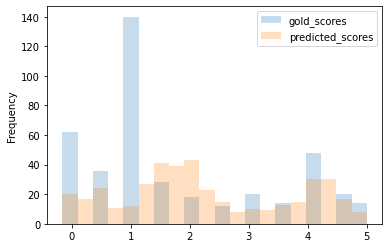

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/dnn-bert-bert-base-uncased-0.84.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/dnn-regression-bert-base-uncased-0.84.pth")

predictions = get_predictions(my_bert, regression, test_dataloader)
gs_scores = open("/content/drive/My Drive/clinical-sts/clinicalSTS2019.test.gs.sim.txt", "r")
actual_scores = [float(x.strip()) for x in gs_scores.readlines()]

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test Dataset Pearson Correlation:  0.8367026416860067
BAD EXAMPLES
actual  predicted     difference     SENTENCE
0.00    2.33          2.33     the patient tolerated the procedure well and was transferred to the recovery room in stable condition. | the patient was transferred to the patient appointment coordinator for an appointment to be scheduled within the timeframe advised.
0.50    3.23          2.73     take a cellphone with you on the way to the emergency department. | reasons to return to the emergency department were discussed.
0.50    2.60          2.10     the patient tolerated the procedure well with no complications. | the patient has no other concerns at this time.
2.50    0.26          2.24     patient seen and discussed with supervising consultant, dr. hand, who evaluated the patient and concurs with the assessment and plan. | the consent form was reviewed with the patient and her partner.
0.00    3.13          3.13     please contact location at phone number with any qu

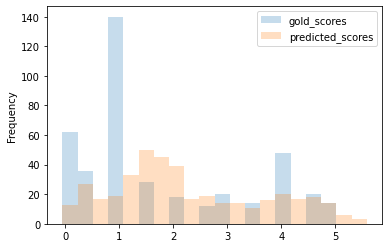

In [ ]:
tokenizer = BertTokenizer.from_pretrained("/content/drive/My Drive/clinical-sts/bio-bert/", output_hidden_states=True)
test_dataloader = load_test_data(tokenizer=tokenizer, batch_size=1)

my_bert = torch.load("/content/drive/My Drive/clinical-sts/models/dnn-new-bert-bio-bert-0.84.pth")
my_bert.cuda()
regression = torch.load("/content/drive/My Drive/clinical-sts/models/dnn-new-regression-bio-bert-0.84.pth")

predictions = get_predictions(my_bert, regression, test_dataloader)
gs_scores = open("/content/drive/My Drive/clinical-sts/clinicalSTS2019.test.gs.sim.txt", "r")
actual_scores = [float(x.strip()) for x in gs_scores.readlines()]

evaluate_predictions(predictions, actual_scores, test_dataloader, show_bad_predictions=True, prediction_difference=2.0)
